<a href="https://colab.research.google.com/github/rgmantovani/advancedML/blob/master/codes/aula_07_swarm/PSO_for_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso de PSO para ML

Disciplina: Métodos e Modelos Avançados em Ciência de Dados

Especialização em Ciência de Dados - Universidade Tecnologica Federal do Paraná

**Aula 07:** Inteligência de Enxames (Swarm Intelligence)

**Exemplo 01:** Ajuste de hiperparâmetros de SVM usando PSO

by: Rafael G. Mantovani

---

In [169]:
# Example baseado em:
# https://pyswarms.readthedocs.io/en/latest/examples/usecases/train_neural_network.html

# Para funcionamento completo do exemplo, precisaremos de duas bibliotecas do python
# pyswarms = implementa Particle Swarm Opitmizatin (PSO)
# openml   = implementa interface com OpenML, e usaremos para baixar datasets

---
# 1. Instruções iniciais
Primeiramente, realizamos a instalação das bibliotecas necessárias (pyswarms, openml). Isso é feito via comando 'pip'. Os dois comandos abaixo, fazem a instalam amabas as bibliotecas.

In [170]:
pip install pyswarms

In [171]:
pip install openml

---
# 2. Carregando todas as dependências

Em seguida, carregamos todas as funções necessárias para execução do nosso exemplo.

In [172]:
# carregando PSO
import pyswarms as ps   
# carregando função para plotar a curva de convergência do PSO
from pyswarms.utils.plotters import plot_cost_history

import openml                     # acesso a datasets do OpenML
import numpy as np                # manipulação de numeros na notação científica
import pandas as pd               # manipulação de data frames no python
import matplotlib.pyplot as plt   # plots/gráficos

import random                     # controle/geracao de numeros aleatorios
from statistics import mean       # media simples

# imports do sklearn
# metodologia experimental - divisão do dataset em subsets, e avaliação de performance
from sklearn.model_selection import train_test_split, cross_val_score
# SVMs para classificacao
from sklearn.svm import SVC
# medidas de desempenho e plot de matriz de confusão
from sklearn.metrics import balanced_accuracy_score,  plot_confusion_matrix
# preprocessamento, se necessário, dos atributos
from sklearn import preprocessing
from sklearn import utils

# dictionary para salvarmos o historico completo o PSO
from collections import defaultdict

In [173]:
# seed para reprodução dos experimentos
seed = 42
random.seed(seed)
np.random.seed(seed)

---
# 3. Obtendo datasets do OpenML

Nesse exemplo, fiz uso dos datasets do OpenML, já citado ao longo das aulas.
Em específico, fiz testes com três datasets diferentes, cada um deles descrevendo um diferente cenário de experimentação:

1. **iris**: SVMs não melhoram com o tuning
2. **analcatdata_boxing2**: SVMs melhoram pouco com o tuning
3. **balance_scale**: SVMs melhoram consideravelmente com o tuning

In [174]:
# Acesso às páginas dos datasets lá no OpenML
# https://www.openml.org/d/61  - iris (SVM não melhora com tuning)
# https://www.openml.org/d/444 - analcatdata_boxing2 (SVM melhora pouco com tuning)
# https://www.openml.org/d/11  - balance scale (SVM melhor consideravelmente com tuning)

In [175]:
#Obtendo dataset via interface de código (biblioteca openml)

# dataset = openml.datasets.get_dataset(444)
# dataset = openml.datasets.get_dataset(61)
dataset = openml.datasets.get_dataset(11) # balance_scale

In [202]:
print(dataset)

OpenML Dataset
Name..........: balance-scale
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:19:55
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/11/balance-scale.arff
OpenML URL....: https://www.openml.org/d/11
# of features.: 5
# of instances: 625


In [203]:
# Converter objeto retornado pelo OpenML em um data frame do pandas
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format = "array", target=dataset.default_target_attribute
)
data = pd.DataFrame(X, columns = attribute_names)
data["target"] = y

2021-04-15 04:25:56,276 - openml.datasets.dataset - INFO - pickle load data balance-scale


In [204]:
#visualizar o data frame - primeiras linhas do df
data.head()

,left-weight,left-distance,right-weight,right-distance,target
0,1.0,1.0,1.0,1.0,1
1,1.0,1.0,1.0,2.0,2
2,1.0,1.0,1.0,3.0,2
3,1.0,1.0,1.0,4.0,2
4,1.0,1.0,1.0,5.0,2


In [179]:
# Se for necessário, descomentar os comados abaixo para converter classe 
#  numérica para valores categóricos

# lab_enc = preprocessing.LabelEncoder()
# data['target'] = lab_enc.fit_transform(data['target'])
# print(data['target'])

---
# 4. Metodologia para o experimento

Para realizar o ajuste dos hiperparâmetros (HPs), vamos dividir o dataset em dois conjuntos:

* treino (**data_train**): o subconjunto de exemplos usados para encontrar os melhores valores de HPs;
* teste (**data_test**): o subconjunto onde iremos testar os melhores valores de HP obtidos durante a otimização.  

Obs: Por ser um exemplo simples, vamos dividir os dados apenas uma vez na proporção 1/3, com 66% dos dados para treinamento, 34% para teste. Em situação reais, geralmente exploramos validação cruzada, repetindo todo esse processo descrito abaixo *K* vezes.


In [205]:
# Dividir os dados em treino e teste
[data_train, data_test] = train_test_split(data, test_size=0.3, random_state=seed, shuffle=True)
print(" - Tamanho do conjunto de treino: ", len(data_train))
print(" - Tamanho do conjunto de teste: ",  len(data_test))

 - Tamanho do conjunto de treino:  437
 - Tamanho do conjunto de teste:  188


In [181]:
# visualizando como ficou o treino
data_train.head()

,left-weight,left-distance,right-weight,right-distance,target
204,2.0,4.0,1.0,5.0,0
88,1.0,4.0,3.0,4.0,2
522,5.0,1.0,5.0,3.0,2
117,1.0,5.0,4.0,3.0,2
416,4.0,2.0,4.0,2.0,1


In [182]:
# visualizando como ficou o teste
data_test.head()

,left-weight,left-distance,right-weight,right-distance,target
447,4.0,3.0,5.0,3.0,2
485,4.0,5.0,3.0,1.0,0
215,2.0,4.0,4.0,1.0,0
212,2.0,4.0,3.0,3.0,2
480,4.0,5.0,2.0,1.0,0


In [183]:
# aqui vamos separar apenas os atributos descritivos (X_train) dos rotulos (y_train)
# no conjunto de treinamento

seq = list(range(0, len(data_train.columns)-1))
X_train = data_train.iloc[:, seq]
X_train.head()

,left-weight,left-distance,right-weight,right-distance
204,2.0,4.0,1.0,5.0
88,1.0,4.0,3.0,4.0
522,5.0,1.0,5.0,3.0
117,1.0,5.0,4.0,3.0
416,4.0,2.0,4.0,2.0


In [206]:
# armazenando os rotulos do conjunto de treinamento em y_train

idx = len(data_train.columns)-1
y_train = data_train.iloc[:,idx]
y_train = y_train.values.ravel()
print(y_train)

[0 2 2 2 1 0 2 1 0 0 2 0 0 0 2 0 2 2 1 2 2 2 0 2 2 2 2 0 0 0 2 0 0 2 2 2 2
 2 2 0 2 2 0 1 2 0 1 2 2 2 0 0 1 0 2 2 0 2 0 0 2 0 2 2 0 0 0 0 0 0 2 0 2 2
 2 0 0 0 2 0 0 2 0 2 2 1 0 2 2 2 2 2 0 2 0 0 0 0 0 0 2 0 2 0 0 0 0 1 2 2 2
 2 0 2 2 0 2 2 0 0 0 2 0 0 0 1 2 2 0 0 2 2 0 1 0 2 0 2 0 0 0 0 2 0 2 0 2 2
 2 0 0 0 0 0 0 0 0 2 0 0 2 2 2 0 0 0 2 0 0 2 0 2 2 2 0 0 2 2 0 2 0 2 2 2 0
 2 2 0 0 2 1 0 2 0 0 2 0 0 2 0 2 0 0 2 2 2 2 2 2 0 2 0 2 0 2 2 0 2 2 0 2 1
 1 1 2 0 2 2 0 0 0 2 2 1 2 2 2 0 0 0 0 0 0 1 2 0 2 2 0 0 2 0 0 0 0 2 2 0 2
 0 0 0 2 2 2 0 2 0 2 0 0 1 0 1 0 2 2 0 0 2 2 0 0 0 0 2 2 0 0 2 0 2 2 2 2 2
 0 2 1 0 2 2 2 2 2 2 0 0 0 0 2 0 2 0 0 0 0 0 0 0 1 2 0 2 0 2 2 2 2 2 0 2 0
 0 2 2 0 2 2 2 0 0 1 2 2 2 1 2 2 0 2 0 1 2 2 1 2 0 2 2 1 1 0 0 0 0 0 0 2 0
 2 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 2 2 1 0 0 2 0 2 2 2 0 0 0 1 2 0 0 2 0 0 2
 2 0 1 2 2 0 0 0 2 0 2 0 2 0 1 2 1 2 0 0 2 0 2 0 2 2 0 2 0 0]


---
#5. Codificação das partículas do PSO

O ajuste de SVM levará em conta dois HPs da implementação com kernel gaussiano (RBF Kernel).

* C: constante de regularização
* gamma: largura do kernel gaussiano

Esses HPs terão possíveis valores mínimos e máximos. Não iremos trabalhar com grids, e sim intervalos reais contínuos.

* C = (0.01, 100)
* gamma = (0.1, 10)

ou seja, as partículas do PSO irão representar uma configuração de HP para SVM, cujos valores hp = {p1, p2}, estão contidos dentro destes intervalos contínuos acima descritos.

Para que o PSO funcione, gere partículas válidas, e as movimente no espaço, precisamos então definir esses limites. Isos é o que fazemos definindo a variável ***bounds***.


In [245]:
# SVM bounds [cost - C, gamma] = [min], [max]
bounds = (np.array([1e-2, 1e-1]), np.array([1e2, 1e1]))
print(bounds)

(array([0.01, 0.1 ]), array([100.,  10.]))


In [246]:
# armazena todas as particulas testadas ao longo da execução do PSO
results_dict = defaultdict(list)
print(results_dict)

defaultdict(<class 'list'>, {})


A função de fitness precisa também ser codificada. No nosso caso, é um função que recebe um conjunto de HPs (candidates), induz SVMs, e calcula a acurácia do modelo com aqueles HPs. 
E é exatamente o que a função abaixo realiza.
A saída (retorno) são as performances de todas as partículas em uma determinada iteração. 

**Obs:** por padrão, as funções do pyswarms realizam otimização minimizando um problema. Assim, para que consigamos gerar performances maiores, só precisamos
multiplicar os valores de retorno por -1.

In [247]:
# customized fitness_function 
def fitness_function(candidates, X_train, y_train, results_dict, seed):

  #print(candidates)
  acc_scores = []
  for pos in candidates:
    
    #print(pos)
    C     = pos[0]
    gamma = pos[1]

    clf = SVC()
    clf.set_params(**{'C': C, 'gamma': gamma})
 
    scores = cross_val_score(clf, X=X_train, y = y_train, cv=3)
    acc = mean(scores)
    acc_scores.append(acc)
    
    # saving results    
    results_dict['seed'].append(seed)
    results_dict['C'].append(C)
    results_dict['gamma'].append(gamma)
    results_dict['acc'].append(acc)

  return -np.array(acc_scores)

---
#6. Executar PSO para tunar SVM

Vamos aqui definir nosso setup do PSO, valor e executar a otimização.


In [260]:
# definir a quantidade de particulas, e o numero de iterações que iremos realizar
n_particles = 20
iters       = 100

In [261]:
# Definir o nosso otimizador, PSO com estratégia global: todas as partículas tem 
# acesso a informação de todas as outras
# Documentação: https://pyswarms.readthedocs.io/en/latest/api/pyswarms.single.html#module-pyswarms.single.global_best

# Opções do PSO (default)
#  c1 - cognitive parameter
#  c2 - social parameter
#  w  = inertia parameter
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

optimizer = ps.single.GlobalBestPSO(
     n_particles = n_particles, 
     dimensions  = 2,  # quantidade de dimensoes do problema (2 = dois HPs)
     bounds      = bounds,
     options     = options
)

In [262]:
# Chamada prinicipal do PSO (executa o PSO)
cost, pos = optimizer.optimize(
    fitness_function,             # funcao de avaliação
    iters = iters,                # qntde de iteracoes
    X_train = X_train,            # conjunto de treinamento p avaliar as partículas
    y_train = y_train,            # labels do conjunto de treinamento
    results_dict = results_dict,  # dictionary p salvar resultados intermediados
    seed = seed                   # seed para reprodução dos experimentos
)                  


2021-04-15 05:08:33,432 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


pyswarms.single.global_best:   0%|          |0/100

pyswarms.single.global_best:   0%|          |0/100, best_cost=-.874

pyswarms.single.global_best:   1%|          |1/100, best_cost=-.874

pyswarms.single.global_best:   1%|          |1/100, best_cost=-.927

pyswarms.single.global_best:   2%|▏         |2/100, best_cost=-.927

pyswarms.single.global_best:   2%|▏         |2/100, best_cost=-.927

pyswarms.single.global_best:   3%|▎         |3/100, best_cost=-.927

pyswarms.single.global_best:   3%|▎         |3/100, best_cost=-.927

pyswarms.single.global_best:   4%|▍         |4/100, best_cost=-.927

pyswarms.single.global_best:   4%|▍         |4/100, best_cost=-.927

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=-.927

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=-.927

pyswarms.single.global_best:   6%|▌         |6/100, best_cost=-

---
#7. Verificar os resultados da otimização

Nessa subseção, vamos ver os resultados da otimização, avaliar os HP retornados, e plotar algumas informações adicionais que podem ser úteis para entender o problema.

In [263]:
# Imprimindo a melhor solução encontrada pela otimização (PSO)
print("Particle = ", pos)         # melhores HPs [C, gamma] no conjunto de treinamento
print("Acc = ", -round(cost,5))   # acurácia de treinamento

Particle =  [42.25305994  0.10274606]
Acc =  0.95651


In [264]:
results_df = pd.DataFrame(results_dict)
print(results_df)

      seed          C     gamma       acc
0       42  37.352687  9.932391  0.475972
1       42  99.481355  1.236384  0.855818
2       42  72.599618  0.612280  0.844387
3       42   3.028900  1.142806  0.848953
4       42  96.548911  9.414549  0.475972
...    ...        ...       ...       ...
6995    42  41.644989  5.344142  0.501102
6996    42  38.089744  3.803416  0.819084
6997    42  43.825410  5.329997  0.501102
6998    42  36.823893  3.923049  0.814517
6999    42  44.239194  4.069540  0.798536

[7000 rows x 4 columns]


In [265]:
# Algumas opções do pyswarms para verificar o histórico da execução
# 1. Obtain the cost history
# optimizer.cost_history
# 2. Obtain the position history
# optimizer.pos_history
# 3. Obtain the velocity history
# optimizer.velocity_history

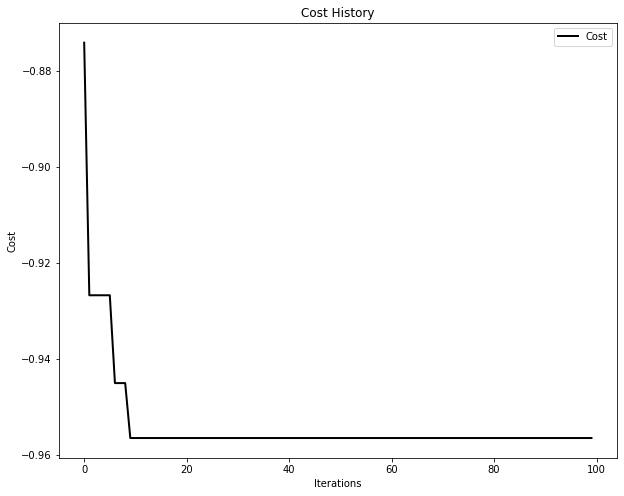

In [266]:
# plotar a convergência da otimização e se conseguimos melhorar as SVMs
plot_cost_history(optimizer.cost_history)
plt.show()

In [267]:
# Testando os melhores HP obtidos pelo PSO

# criando uma SVM
clf = SVC()
# atribuindo os HPs que encontramos
clf.set_params(**{'C': pos[0], 'gamma': pos[1]})
# treinando o algoritmo no conjunto de treinamento
clf.fit(X_train, y_train)

SVC(C=42.25305993512952, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.10274605755697663, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [268]:
# Repetindo o tratamento realizado no conjunto de treinamento, mas agora
# no conjunto de teste: separando em X_test (atributos descritivos) e y_test (label)
seq = list(range(0, len(data_test.columns)-1))
X_test = data_test.iloc[:, seq]
X_test.head()

idx = len(data_test.columns)-1
y_test = data_test.iloc[:,idx]
y_test = y_test.values.ravel()

print(y_test)

[2 0 0 2 0 0 2 0 0 2 2 2 0 1 0 0 2 2 2 1 2 2 2 0 0 0 2 0 0 2 0 2 2 0 2 0 0
 0 0 2 1 2 2 0 2 1 1 2 1 2 0 0 2 2 0 0 2 0 0 1 0 0 2 2 0 0 2 2 0 0 2 2 2 2
 2 0 0 2 0 2 2 1 2 0 2 1 0 0 2 0 0 0 2 0 0 2 2 2 2 2 0 1 2 2 0 1 0 2 2 0 2
 0 2 2 0 2 0 0 0 0 2 2 0 2 2 2 2 2 1 2 0 0 1 2 0 0 0 2 0 0 0 2 2 2 0 2 2 0
 2 2 2 2 2 0 2 2 1 0 1 0 0 2 2 0 0 0 2 0 2 1 0 2 2 2 1 0 0 0 2 0 2 1 0 2 2
 2 2 0]


In [269]:
# realizando as predições para o conjunto de teste, 
#  e estimando a peformance da SVM tunada
y_pred = clf.predict(X_test)
print("Acc test = ", balanced_accuracy_score(y_test, y_pred))

Acc test =  0.8740740740740741


In [270]:
# Comparando predicoes e labels reais, exemplo por exemplo, no conjunto de teste
df = pd.DataFrame(np.array([y_pred, y_test]))
df = df.rename(index = {0:"y_pred", 1:"y_test"})
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
y_pred,2,0,0,1,0,0,2,0,0,2,2,2,0,1,0,0,2,1,1,1,2,2,2,0,0,0,2,0,0,1,0,2,2,0,2,0,0,0,0,2,...,2,2,2,2,2,0,0,2,1,0,0,0,0,2,2,0,0,0,2,0,2,1,0,2,2,2,1,0,0,0,2,0,2,2,0,2,0,2,2,0
y_test,2,0,0,2,0,0,2,0,0,2,2,2,0,1,0,0,2,2,2,1,2,2,2,0,0,0,2,0,0,2,0,2,2,0,2,0,0,0,0,2,...,2,2,2,2,2,0,2,2,1,0,1,0,0,2,2,0,0,0,2,0,2,1,0,2,2,2,1,0,0,0,2,0,2,1,0,2,2,2,2,0


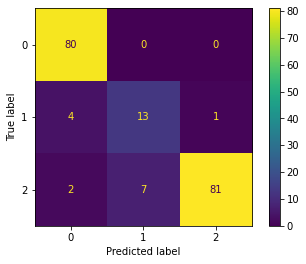

In [271]:
# Podemos também plotar a matriz de confusão da nossa SVM tunada
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()  

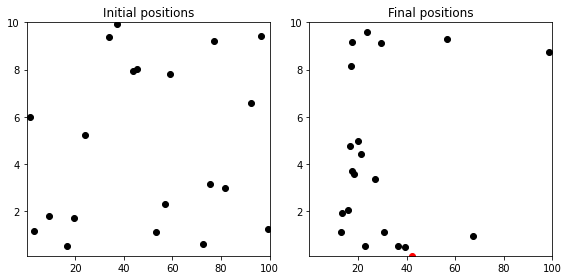

In [272]:
#E por fim comparar as posições das partículas no Hiperespaço dos HPs
# - posicoes iniciais
# - posicões finais

plt.figure(figsize=(8, 4))

# initial population sub-plot
plt.subplot(1,2,1)
initial_pos = results_df.iloc[0:n_particles,:]
plt.scatter(x=initial_pos['C'], y=initial_pos['gamma'], color="black")
plt.xlim(bounds[0][0], bounds[1][0]) 
plt.ylim(bounds[0][1], bounds[1][1])
plt.title("Initial positions")

# final population sub-plot
plt.subplot(1,2,2)
final_pos   = results_df.iloc[((iters-1)*n_particles):(n_particles*iters), :]
plt.scatter(x=final_pos['C'], y=final_pos['gamma'], color="black")
plt.scatter(x=pos[0], y=pos[1], color="red")
plt.title("Final positions")
plt.xlim(bounds[0][0], bounds[1][0]) 
plt.ylim(bounds[0][1], bounds[1][1])

plt.tight_layout() 
plt.show()

---
# Considerações finais

A estrutura desse *notebook* permite adaptar o problema para realizar o tuning de diferentes algoritmos de ML. Além disso, o PSO também pode ser aplicado para realizar a seleção de atributos, principalmente em problemas que sofre da maldição da dimensionalidade (muitos atributos/colunas). Nesse caso, a função objetivo (fitness) ao invés de testar diferentes HPs irá gerar diferentes combinações de colunas do dataset original, e avaliar o algoritmo nesse novo subset. Dessa forma, o otimizador (PSO), irá tentar maximizar a peformance no conjunto de treinamento. A implementação em si não sofre grandes mofificações, e fica como exercício.

Bons estudos :)